<a href="https://colab.research.google.com/github/mirellanascimento/PLN/blob/main/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dectection of Hate Speech Using a Brazilian Twitter Dataset



In [1]:
#!pip install gensim
#!pip install python-Levenshtein

In [2]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D,MaxPooling2D,Activation,Flatten, Dropout, concatenate, Conv2D, Reshape, Input
from keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Remoção de stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv')

In [5]:
df.head()

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0


Como o problema a ser solucionado é de classificação de duas classes, ofensivo ou não, o dataset precisa ser transformado para representar esse tipo de problema

In [6]:
def label(a, b, c, d, e, f):
  if a == b == c == d == e == f == 0:
    return 'non-toxic'
  else: 
    return 'toxic'

df['label'] = df.apply(lambda row : label(row['homophobia'], row['obscene'], row['insult'], 
                                          row['racism'], row['misogyny'], row['xenophobia']), axis = 1)

In [7]:
df

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,label
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0,toxic
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0,toxic
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0,toxic
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0,toxic
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0,toxic
...,...,...,...,...,...,...,...,...
20995,@user faz favor vai carai,0.0,0.0,0.0,0.0,0.0,0.0,non-toxic
20996,só queria conhecer alguém que não conhece o he...,1.0,0.0,0.0,0.0,0.0,0.0,toxic
20997,"vcs militam na hora errada em cima de memes, p...",0.0,0.0,0.0,0.0,0.0,0.0,non-toxic
20998,@user porra any eu tava c dor de cabeca e fui ...,0.0,0.0,0.0,0.0,0.0,0.0,non-toxic


In [8]:
df = df[['text', 'label']]
df.head()

,text,label
0,Meu nivel de amizade com isis é ela ter meu in...,toxic
1,"rt @user @user o cara adultera dados, que fora...",toxic
2,@user @user @user o cara só é simplesmente o m...,toxic
3,eu to chorando vei vsf e eu nem staneio izone ...,toxic
4,Eleitor do Bolsonaro é tão ignorante q não per...,toxic


## Pre-processing


In [9]:
def pre_processing(input_text):

  stop_words = set(stopwords.words('portuguese'))

  #for emot in EMOTICONS:
  #  input_text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), input_text)

  words = re.sub(r'@[A-Za-z0-9]+', " ", input_text.lower())
  words = re.sub(r'https?://\S+|www\.\S+', "", words)
  words = re.sub(r'rt[\s]+', "", words)
  words = re.sub(r'[^\w\s]', "", words)
  words = words.strip()
  
  phrase = ""
  words = words.split()

  for x in words:
    if x not in stop_words:
      phrase = phrase + " " + x

     
  return phrase

df['text'] = np.vectorize(pre_processing)(df['text']) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df

,text,label
0,nivel amizade isis ter insta ter penso manda ...,toxic
1,cara adultera dados desmascarados ainda quer ...,toxic
2,cara simplesmente maior vencedor história fut...,toxic
3,to chorando vei vsf staneio izone nada,toxic
4,eleitor bolsonaro tão ignorante q percebeu q ...,toxic
...,...,...
20995,faz favor vai carai,non-toxic
20996,queria conhecer alguém conhece hetero taubaté...,toxic
20997,vcs militam hora errada cima memes ngm suport...,non-toxic
20998,porra any tava c dor cabeca comer mpn nowunit...,non-toxic


In [11]:
df['label'].value_counts()

non-toxic    11745
toxic         9255
Name: label, dtype: int64

In [12]:
X = np.array(df['text'])
X

array([' nivel amizade isis ter insta ter penso manda mensagem falano otario ta falando dnv insta',
       ' cara adultera dados desmascarados ainda quer ficar governo',
       ' cara simplesmente maior vencedor história futebol tá 36 anos gás demais gordo joelho fodido',
       ...,
       ' vcs militam hora errada cima memes ngm suporta jovem militância errada porra militar cima meme foda',
       ' porra any tava c dor cabeca comer mpn nowunited uniters',
       ' saudades iasmin 2017 gótica demais pqp'], dtype=object)

In [13]:
y = np.array(df['label'])
y

array(['toxic', 'toxic', 'toxic', ..., 'non-toxic', 'non-toxic',
       'non-toxic'], dtype=object)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    train_size=0.8, 
                                                    random_state=42)
  

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,
                                                    test_size=0.2, 
                                                    random_state=42)

## Word2Vec + Embedding Layer

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].to_numpy())
word2index = tokenizer.word_index # word_index assigns a unique index to each character present in the text.
vocab_size = len(word2index)

In [17]:
lista = []
for i in df['text']:
  lista.append(i.split())
  
model = Word2Vec(lista, window = 3, min_count = 1, workers = 4, sg = 1)  

In [18]:
word_vectors = model.wv

In [19]:
# Converter dados para uma matrix de shape(27654, 100)
embedding_dim = 100
vocabulary_size = len(word2index) + 1

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in word2index.items():
    if i >= vocab_size:
        continue

    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,1,embedding_dim)

In [20]:
max_length = 50

In [21]:
# Criar a embedding layer 
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

## Numecarilização

In [22]:
y_train = pd.Categorical(y_train)
y_train_int = y_train.codes

y_test = pd.Categorical(y_test)
y_test_int = y_test.codes

y_valid = pd.Categorical(y_valid)
y_valid_int = y_valid.codes

y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)
y_valid = to_categorical(y_valid_int)


In [23]:
#y_train, y_test, y_valid = loggits(y_train, y_test, y_valid)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
valid_sequences = tokenizer.texts_to_sequences(X_valid)


In [24]:
trunc_type = 'post'
padding_type = 'post'
  
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## CNN

In [25]:
model = Sequential()

model.add(embedding_layer) 
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Conv1D(filters=128, kernel_size=4, activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2765400   
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           25728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 128)          0         
 1D)                                                    

In [26]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="binary_crossentropy",optimizer=sgd,metrics=['accuracy'])
history = model.fit(train_padded,y_train, validation_data=(valid_padded,y_valid), batch_size=64,epochs=100)

Epoch 1/100
210/210 [==============================] - 10s 44ms/step - loss: 0.6911 - accuracy: 0.5478 - val_loss: 0.6885 - val_accuracy: 0.5598
Epoch 2/100
210/210 [==============================] - 9s 43ms/step - loss: 0.6885 - accuracy: 0.5580 - val_loss: 0.6872 - val_accuracy: 0.5598
Epoch 3/100
210/210 [==============================] - 9s 43ms/step - loss: 0.6880 - accuracy: 0.5580 - val_loss: 0.6867 - val_accuracy: 0.5598
Epoch 4/100
210/210 [==============================] - 9s 42ms/step - loss: 0.6878 - accuracy: 0.5578 - val_loss: 0.6862 - val_accuracy: 0.5598
Epoch 5/100
210/210 [==============================] - 9s 42ms/step - loss: 0.6870 - accuracy: 0.5577 - val_loss: 0.6858 - val_accuracy: 0.5598
Epoch 6/100
210/210 [==============================] - 9s 42ms/step - loss: 0.6866 - accuracy: 0.5577 - val_loss: 0.6854 - val_accuracy: 0.5598
Epoch 7/100
210/210 [==============================] - 9s 42ms/step - loss: 0.6860 - accuracy: 0.5589 - val_loss: 0.6850 - val_accuracy

In [27]:
scores = model.evaluate(test_padded, y_test, verbose=0)
print(f"Accuracy: {(scores[1]*100)}")

Accuracy: 66.73809289932251


In [28]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74      2370
           1       0.69      0.44      0.53      1830

    accuracy                           0.67      4200
   macro avg       0.67      0.64      0.64      4200
weighted avg       0.67      0.67      0.65      4200



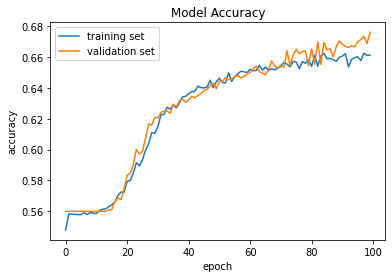

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

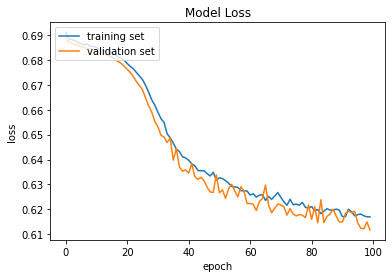

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

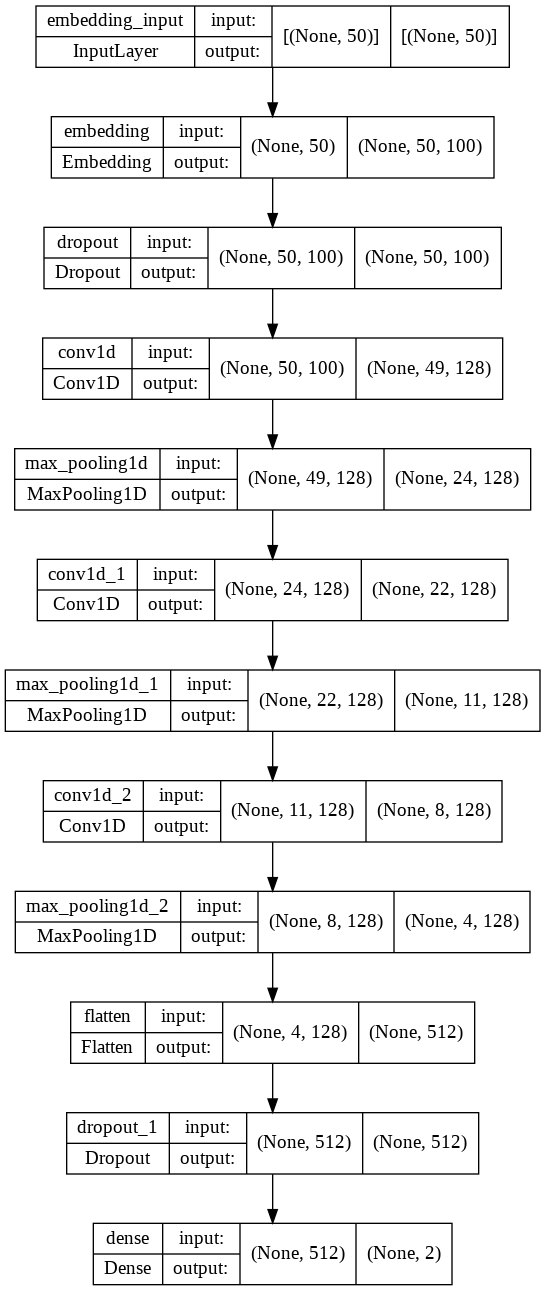

In [31]:
tf.keras.utils.plot_model(model,'model_image.png', show_shapes = True)